In [1]:
import pandas as pd
from logistic_regression import FederatedLogisticRegression
from evaluate_model import compare_logistic_models
from federate_agregation import federated_averaging

In [2]:
df_be= pd.read_csv('../data/belgium_data.csv')
df_eu= pd.read_csv('../data/european_data.csv')
df_fr= pd.read_csv('../data/french_data.csv')

In [3]:
dict_fr= {'dataframe':df_fr,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dict_be= {'dataframe':df_be,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dict_eu= {'dataframe':df_eu,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dataframes= [dict_fr, dict_be, dict_eu]

In [4]:
def setup_local_models(dataframes):
    for df in dataframes:
        lr=FederatedLogisticRegression(df['dataframe'])
        X_test= lr.X_test
        y_test= lr.y_test
        y_proba, y_pred, coefs = lr.logistic_regression()
        df['X_test']=X_test
        df['y_test']=y_test
        df['y_proba_local']=y_proba
        df['y_pred_local']=y_pred
        df['coefs']=coefs
    return dataframes

In [5]:
#dataframes= setup_local_models(dataframes)
#dataframes
dict_be["dataframe"]

,Exposure,Power,DriverAge,Fuel_type,Density,Sex,Sinistre
0,1.000000,77,50,0,13928,1,1
1,1.000000,66,64,0,13928,0,0
2,1.000000,70,60,1,13928,1,0
3,1.000000,57,77,0,13928,1,0
4,0.046575,70,28,0,13928,0,1
...,...,...,...,...,...,...,...
163207,1.000000,40,37,1,259,1,0
163208,1.000000,55,44,1,259,1,0
163209,1.000000,40,50,1,259,1,0
163210,1.000000,66,43,0,259,1,0


In [7]:
def setup_local_models(dataframes):
    for df in dataframes:
        lr = FederatedLogisticRegression(df["dataframe"])
        X_test = lr.X_test
        y_test = lr.y_test
        y_proba, y_pred, coefs = lr.logistic_regression()
        df['X_test'] = X_test
        df["X_test"] = pd.DataFrame(
            lr.scaler.transform(df["X_test"]),
            columns=df["X_test"].columns,
            index=df["X_test"].index)
        
        df['y_test'] = y_test
        df['y_proba_local'] = y_proba
        df['y_pred_local'] = y_pred
        df['coefs'] = coefs
        df['best_threshold'] = lr.best_threshold
        df['lr'] = lr
    return dataframes


def setup_model(dataframes):
    dataframes = setup_local_models(dataframes)
    coeffs = federated_averaging(dataframes)

    for df in dataframes:
        lr = df["lr"]
        threshold = df["best_threshold"]
        df["y_proba_global"], df["y_pred_global"] = lr.predict_with_coefficients(
            df["X_test"], coeffs, best_threshold=threshold
        )

    return dataframes


In [8]:
#dataframes = setup_local_models(dataframes)

In [9]:
dict_fr = dataframes[0]
dict_fr["X_test"] 

In [10]:
dataframes=setup_model(dataframes)

📊 Poids des datasets dans la moyenne fédérée :
 - Dataset 1: 30.09%
 - Dataset 2: 4.50%
 - Dataset 3: 65.41%


In [11]:
dict_fr=dataframes[0]
dict_be=dataframes[1]
dict_eu=dataframes[2]

In [12]:
dict_fr["best_threshold"]

np.float64(0.4989778378529589)

In [13]:
dict_fr["y_proba_global"][:10]


array([0.47491746, 0.51334284, 0.51542271, 0.47139317, 0.52433622,
       0.47509474, 0.60313888, 0.47479919, 0.5765338 , 0.50345927])

In [14]:
dict_fr["y_proba_local"][:10]

[0.43164085694436966,
 0.5257772520830497,
 0.5263452269170855,
 0.5020484226167836,
 0.5244680185551703,
 0.5247699109040148,
 0.5306160551200334,
 0.5215874107637718,
 0.6281381448424342,
 0.5282059497193586]

In [15]:
dict_fr["X_test"]

,Power,DriverAge,Fuel_type,Density,Sex
346702,1.964141,-0.171349,-0.986754,-0.397135,0.816367
667721,-0.678877,-0.030613,1.013424,-0.400633,0.816367
841451,-0.566408,0.954534,1.013424,-0.254387,-1.224939
127047,-0.453939,-0.030613,-0.986754,-0.135197,0.816367
1083456,-0.510174,-0.523187,1.013424,0.089888,0.816367
...,...,...,...,...,...
675452,-0.735112,1.165637,1.013424,-0.424658,0.816367
604781,-0.735112,-0.171349,1.013424,-0.428856,-1.224939
37332,-0.453939,0.110122,-0.986754,0.124409,0.816367
961582,-0.566408,0.461960,-0.986754,-0.427923,0.816367


In [16]:
dict_fr["y_proba_global"][:20]

array([0.47491746, 0.51334284, 0.51542271, 0.47139317, 0.52433622,
       0.47509474, 0.60313888, 0.47479919, 0.5765338 , 0.50345927,
       0.4761394 , 0.53924978, 0.53304041, 0.46363961, 0.52572588,
       0.4685706 , 0.46446064, 0.48282258, 0.50010551, 0.49318342])

In [17]:
dict_fr["best_threshold"]

np.float64(0.4989778378529589)

In [18]:
dict_fr["y_proba_global"][:20]-dict_fr["y_proba_local"][:20]

array([ 0.04327661, -0.01243441, -0.01092252, -0.03065525, -0.0001318 ,
       -0.04967517,  0.07252282, -0.04678822, -0.05160434, -0.02474668,
       -0.02521314,  0.06210423,  0.02151057, -0.0490033 , -0.01459323,
       -0.00430154, -0.05234039, -0.04821344, -0.02045309,  0.04420448])

In [19]:
pd.Series(dataframes[2]["y_pred_global"]).value_counts()

0    315846
1    277249
Name: count, dtype: int64

📊 Poids des datasets dans la moyenne fédérée :
 - Dataset 1: 30.09%
 - Dataset 2: 4.50%
 - Dataset 3: 65.41%


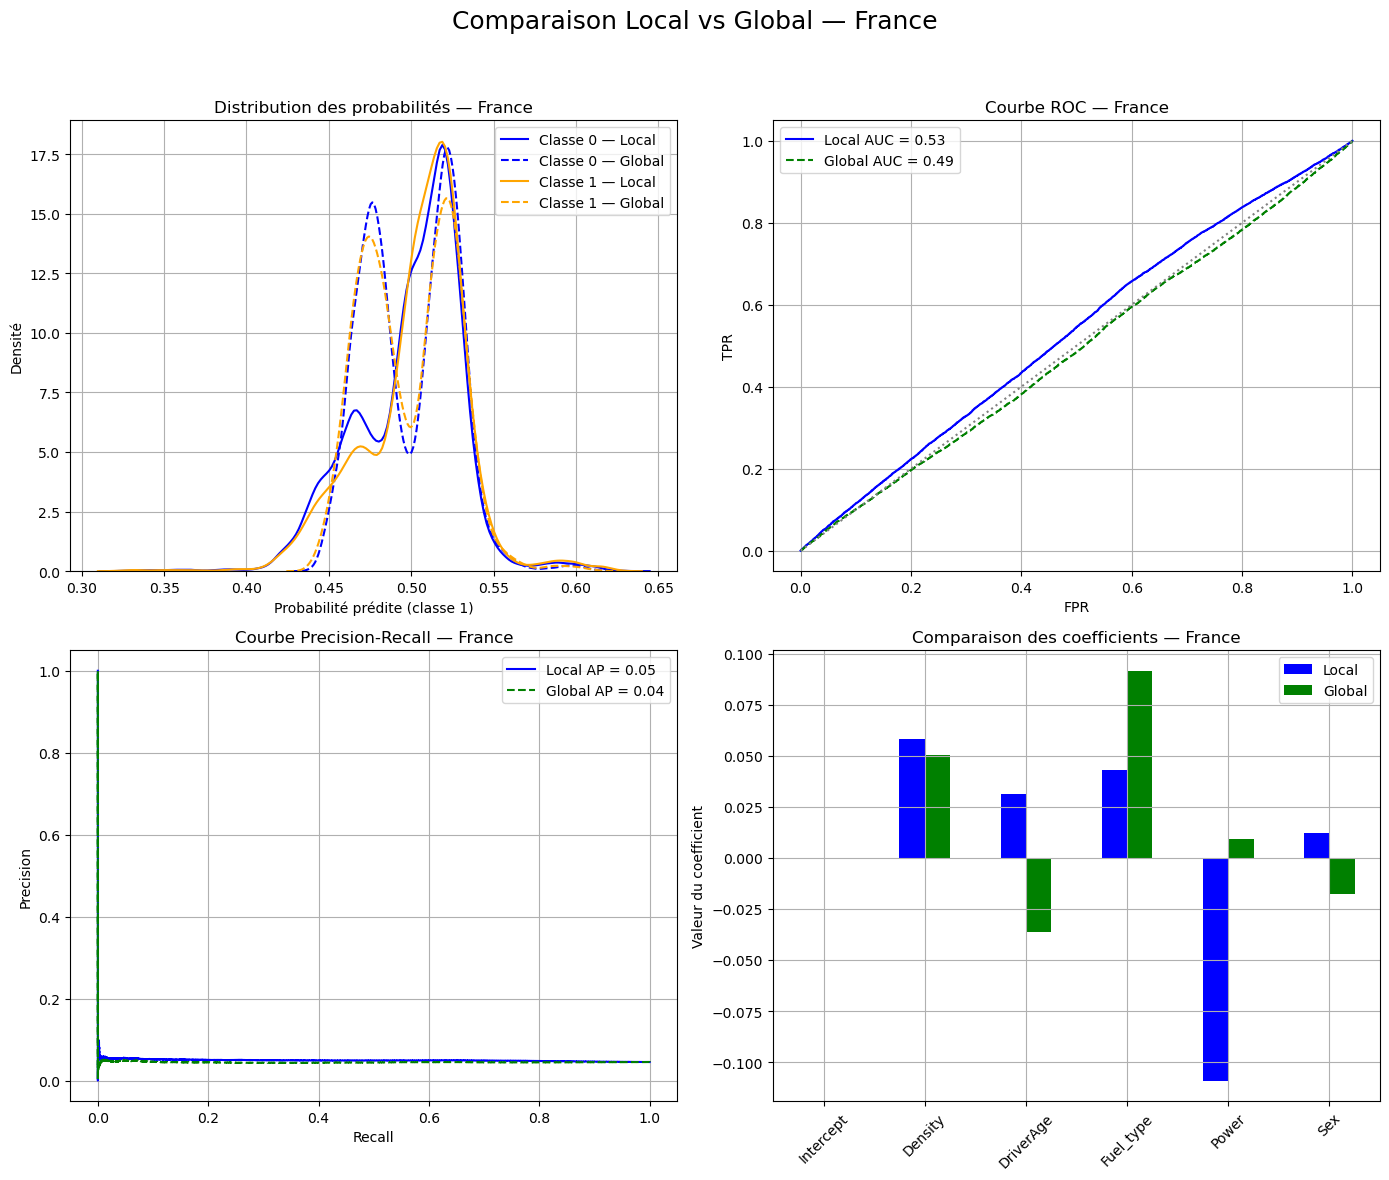


📋 [Local] Classification Report — France
              precision    recall  f1-score   support

           0       0.96      0.41      0.57    260435
           1       0.05      0.65      0.09     12361

    accuracy                           0.42    272796
   macro avg       0.51      0.53      0.33    272796
weighted avg       0.92      0.42      0.55    272796

📌 AUC ROC (Local) : 0.5308
📌 Average Precision (Local) : 0.0494
🧮 Confusion Matrix (Local):
 [[106769 153666]
 [  4349   8012]]

📋 [Global] Classification Report — France
              precision    recall  f1-score   support

           0       0.95      0.48      0.64    260435
           1       0.04      0.50      0.08     12361

    accuracy                           0.48    272796
   macro avg       0.50      0.49      0.36    272796
weighted avg       0.91      0.48      0.62    272796

📌 AUC ROC (Global) : 0.4907
📌 Average Precision (Global) : 0.0446
🧮 Confusion Matrix (Global):
 [[125634 134801]
 [  6134   6227]]


In [20]:
compare_logistic_models(
    y_true=dict_fr['y_test'],
    y_pred_local=dict_fr['y_pred_local'],
    y_scores_local=dict_fr['y_proba_local'],
    coeff_dict_local=dict_fr['coefs'],
    y_pred_global=dict_fr['y_pred_global'],
    y_scores_global=dict_fr['y_proba_global'],
    coeff_dict_global=federated_averaging(dataframes),
    name="France"
)

📊 Poids des datasets dans la moyenne fédérée :
 - Dataset 1: 30.09%
 - Dataset 2: 4.50%
 - Dataset 3: 65.41%


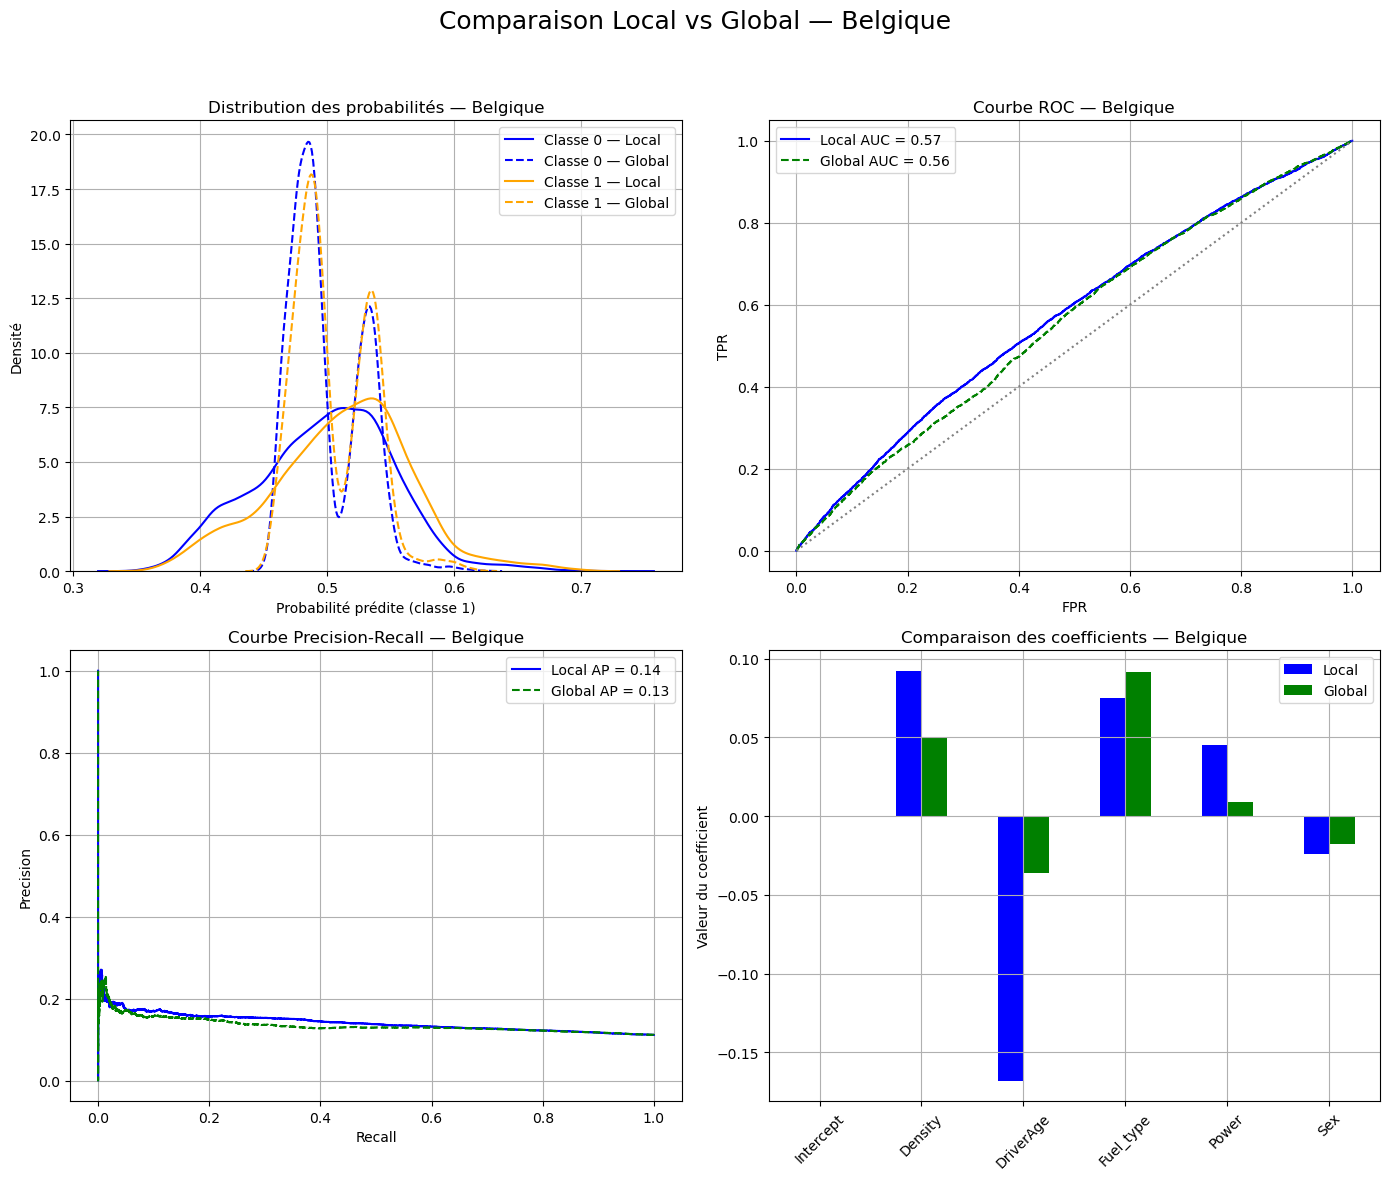


📋 [Local] Classification Report — Belgique
              precision    recall  f1-score   support

           0       0.91      0.54      0.67     36251
           1       0.13      0.57      0.22      4552

    accuracy                           0.54     40803
   macro avg       0.52      0.55      0.45     40803
weighted avg       0.82      0.54      0.62     40803

📌 AUC ROC (Local) : 0.5735
📌 Average Precision (Local) : 0.1415
🧮 Confusion Matrix (Local):
 [[19416 16835]
 [ 1948  2604]]

📋 [Global] Classification Report — Belgique
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     36251
           1       0.13      0.40      0.19      4552

    accuracy                           0.63     40803
   macro avg       0.51      0.53      0.48     40803
weighted avg       0.81      0.63      0.69     40803

📌 AUC ROC (Global) : 0.5601
📌 Average Precision (Global) : 0.1347
🧮 Confusion Matrix (Global):
 [[23748 12503]
 [ 2722  1830]]


In [21]:
compare_logistic_models(
    y_true=dict_be['y_test'],
    y_pred_local=dict_be['y_pred_local'],
    y_scores_local=dict_be['y_proba_local'],
    coeff_dict_local=dict_be['coefs'],
    y_pred_global=dict_be['y_pred_global'],
    y_scores_global=dict_be['y_proba_global'],
    coeff_dict_global=federated_averaging(dataframes),
    name="Belgique"
)

📊 Poids des datasets dans la moyenne fédérée :
 - Dataset 1: 30.09%
 - Dataset 2: 4.50%
 - Dataset 3: 65.41%


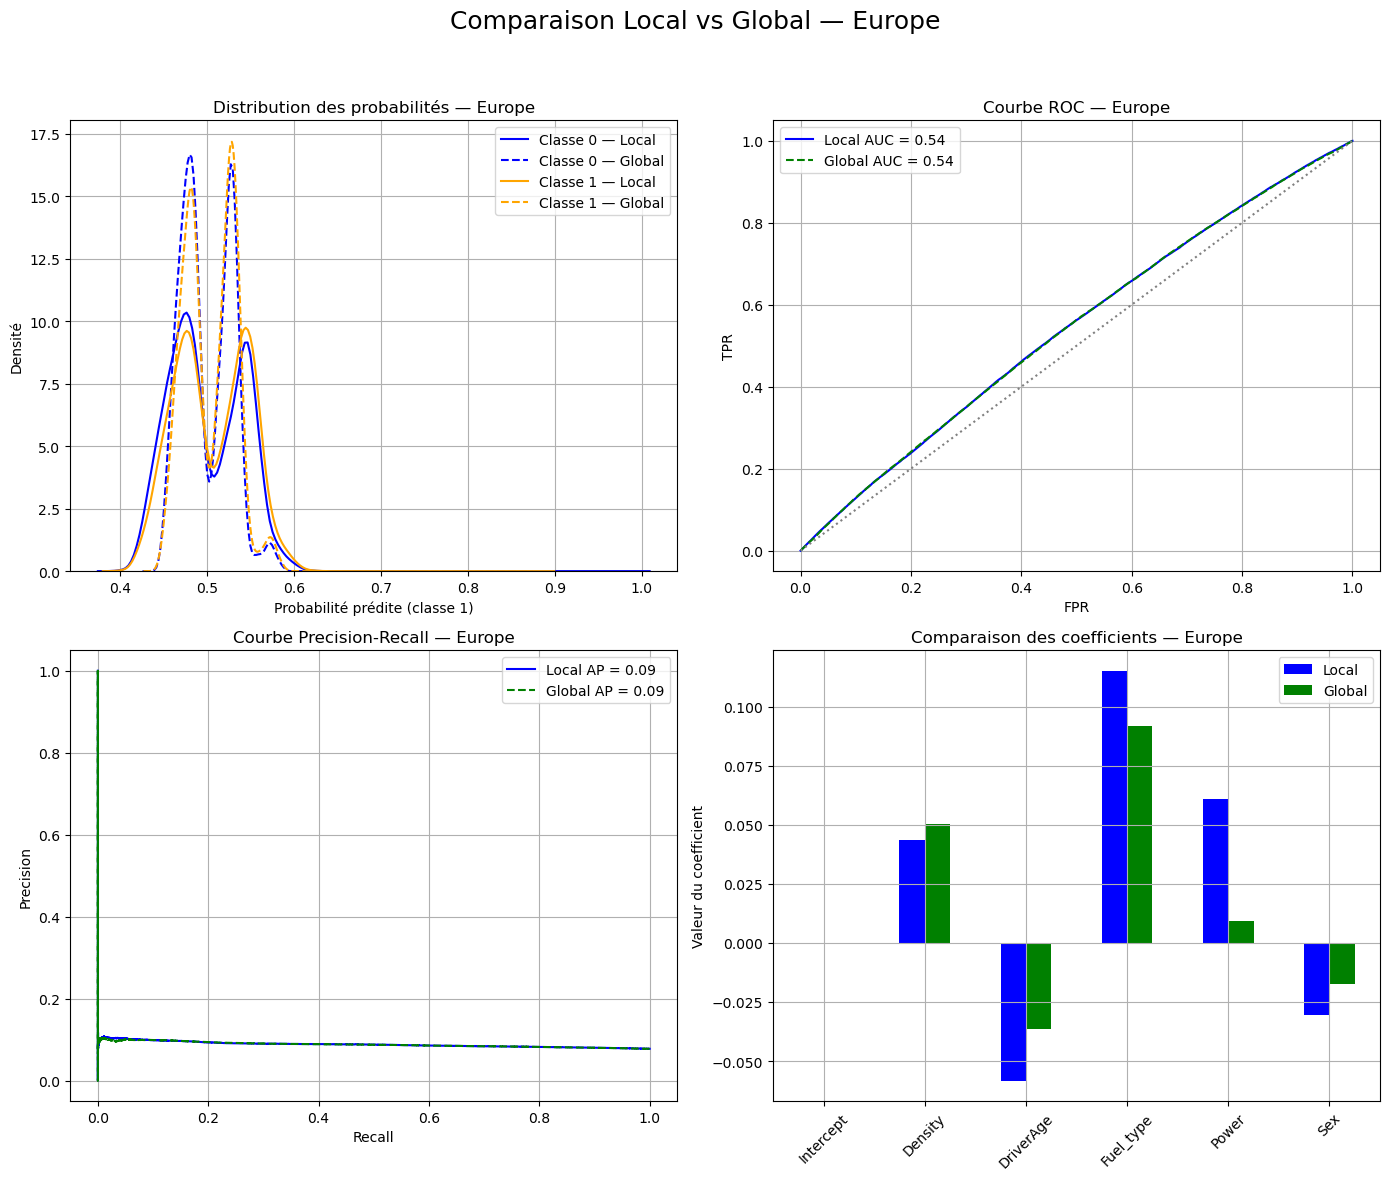


📋 [Local] Classification Report — Europe
              precision    recall  f1-score   support

           0       0.93      0.54      0.68    547102
           1       0.09      0.52      0.15     45993

    accuracy                           0.54    593095
   macro avg       0.51      0.53      0.42    593095
weighted avg       0.87      0.54      0.64    593095

📌 AUC ROC (Local) : 0.5426
📌 Average Precision (Local) : 0.0881
🧮 Confusion Matrix (Local):
 [[295842 251260]
 [ 21936  24057]]

📋 [Global] Classification Report — Europe
              precision    recall  f1-score   support

           0       0.93      0.54      0.68    547102
           1       0.09      0.52      0.15     45993

    accuracy                           0.54    593095
   macro avg       0.51      0.53      0.42    593095
weighted avg       0.87      0.54      0.64    593095

📌 AUC ROC (Global) : 0.5424
📌 Average Precision (Global) : 0.0879
🧮 Confusion Matrix (Global):
 [[293999 253103]
 [ 21847  24146]]


In [22]:
compare_logistic_models(
    y_true=dict_eu['y_test'],
    y_pred_local=dict_eu['y_pred_local'],
    y_scores_local=dict_eu['y_proba_local'],
    coeff_dict_local=dict_eu['coefs'],
    y_pred_global=dict_eu['y_pred_global'],
    y_scores_global=dict_eu['y_proba_global'],
    coeff_dict_global=federated_averaging(dataframes),
    name="Europe"
)